In [65]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
input_output_matrix = {
    ('A', 'A'): 0.20, ('A', 'M'): 0.10, ('A', 'S'): 0.05, ('A', 'I'): 0.08,
    ('M', 'A'): 0.05, ('M', 'M'): 0.25, ('M', 'S'): 0.10, ('M', 'I'): 0.12,
    ('S', 'A'): 0.02, ('S', 'M'): 0.06, ('S', 'S'): 0.15, ('S', 'I'): 0.05,
    ('I', 'A'): 0.01, ('I', 'M'): 0.04, ('I', 'S'): 0.02, ('I', 'I'): 0.18
}

demand = {
    'A': 50,
    'M': 75,
    'S': 50,
    'I': 40
}

value_added = {
    'A': 0.6,
    'M': 0.8,
    'S': 0.75,
    'I': 0.9
}

labor_req = {
    'A': 2,
    'M': 3,
    'S': 1,
    'I': 3
}

capital_req = {
    'A': 1.1,
    'M': 2.0,
    'S': 0.8,
    'I': 2.5
}

emission_req = {
    'A': 0.5,
    'M': 0.9,
    'S': 0.3,
    'I': 1.1
}

export_pct_limit = {
    'A': 0.30,
    'M': 0.40,
    'S': 0.15,
    'I': 0.10
}

export_abs_limit = {
    'A': 60,
    'M': 80,
    'S': 30,
    'I': 25
}

total_labor = 1000
total_capital = 1200
total_emission = 400
infra_budget = 120

sectors = ['A', 'M', 'S', 'I']

print("Data dan parameter berhasil didefinisikan:")
print(f"  Jumlah sektor: {len(sectors)}")
print(f"  Total tenaga kerja: {total_labor}")
print(f"  Total modal: {total_capital}")
print(f"  Total emisi maksimum: {total_emission}")
print(f"  Anggaran infrastruktur: {infra_budget}")

Data dan parameter berhasil didefinisikan:
  Jumlah sektor: 4
  Total tenaga kerja: 1000
  Total modal: 1200
  Total emisi maksimum: 400
  Anggaran infrastruktur: 120


In [ ]:
A_matrix = np.array([
    [input_output_matrix[('A', 'A')], input_output_matrix[('A', 'M')],
     input_output_matrix[('A', 'S')], input_output_matrix[('A', 'I')]],
    [input_output_matrix[('M', 'A')], input_output_matrix[('M', 'M')],
     input_output_matrix[('M', 'S')], input_output_matrix[('M', 'I')]],
    [input_output_matrix[('S', 'A')], input_output_matrix[('S', 'M')],
     input_output_matrix[('S', 'S')], input_output_matrix[('S', 'I')]],
    [input_output_matrix[('I', 'A')], input_output_matrix[('I', 'M')],
     input_output_matrix[('I', 'S')], input_output_matrix[('I', 'I')]]
])

d_vector = np.array([demand['A'], demand['M'], demand['S'], demand['I']])

I_minus_A = np.eye(4) - A_matrix

try:
    leontief_inverse = np.linalg.inv(I_minus_A)
    min_production = leontief_inverse @ d_vector

    print("Minimum produksi untuk memenuhi permintaan akhir:")
    for i, sector in enumerate(sectors):
        print(f"  {sector}: {min_production[i]:.2f}")

    print("\nCek terhadap batasan sumber daya:")
    min_labor = sum(labor_req[sectors[i]] * min_production[i] for i in range(4))
    labor_status = "OK" if min_labor <= total_labor else "INFEASIBLE"
    print(f"  Tenaga Kerja: {min_labor:.2f} / {total_labor} [{labor_status}]")

    min_capital = sum(capital_req[sectors[i]] * min_production[i] for i in range(4))
    capital_status = "OK" if min_capital <= total_capital else "INFEASIBLE"
    print(f"  Modal: {min_capital:.2f} / {total_capital} [{capital_status}]")

    min_emission = sum(emission_req[sectors[i]] * min_production[i] for i in range(4))
    emission_status = "OK" if min_emission <= total_emission else "INFEASIBLE"
    print(f"  Emisi: {min_emission:.2f} / {total_emission} [{emission_status}]")

    infra_status = "OK" if min_production[3] <= infra_budget else "INFEASIBLE"
    print(f"  Infrastruktur Budget: {min_production[3]:.2f} / {infra_budget} [{infra_status}]")

except np.linalg.LinAlgError:
    print("Error: Matriks (I-A) singular")


Minimum produksi untuk memenuhi permintaan akhir:
  A: 88.45
  M: 124.88
  S: 73.12
  I: 57.73

Cek terhadap batasan sumber daya:
  Tenaga Kerja: 797.88 / 1000 [OK]
  Modal: 549.89 / 1200 [OK]
  Emisi: 242.06 / 400 [OK]
  Infrastruktur Budget: 57.73 / 120 [OK]



In [ ]:
model = pyo.ConcreteModel(name="GDP_Optimization")

model.sectors = pyo.Set(initialize=sectors)

model.production = pyo.Var(model.sectors, domain=pyo.NonNegativeReals)

print("Variabel keputusan: production[sector] >= 0")
print()

def objective_rule(m):
    return sum(value_added[i] * m.production[i] for i in m.sectors)

model.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

print("Fungsi objektif: Maximize PDB = 0.6*p_A + 0.8*p_M + 0.75*p_S + 0.9*p_I")
print()

def balance_constraint_rule(m, i):
    return m.production[i] >= demand[i] + sum(
        input_output_matrix[(i, j)] * m.production[j] for j in m.sectors
    )

model.balance_constraint = pyo.Constraint(model.sectors, rule=balance_constraint_rule)

print("Constraint 1: Balance")
print("  p_i >= d_i + sum(a_ij * p_j)")
print()

def labor_constraint_rule(m):
    return sum(labor_req[i] * m.production[i] for i in m.sectors) <= total_labor

model.labor_constraint = pyo.Constraint(rule=labor_constraint_rule)

print("Constraint 2: Labor")
print(f"  2*p_A + 3*p_M + 1*p_S + 3*p_I <= {total_labor}")
print()

def capital_constraint_rule(m):
    return sum(capital_req[i] * m.production[i] for i in m.sectors) <= total_capital

model.capital_constraint = pyo.Constraint(rule=capital_constraint_rule)

print("Constraint 3: Capital")
print(f"  1.1*p_A + 2.0*p_M + 0.8*p_S + 2.5*p_I <= {total_capital}")
print()

def emission_constraint_rule(m):
    return sum(emission_req[i] * m.production[i] for i in m.sectors) <= total_emission

model.emission_constraint = pyo.Constraint(rule=emission_constraint_rule)

print("Constraint 4: Emission")
print(f"  0.5*p_A + 0.9*p_M + 0.3*p_S + 1.1*p_I <= {total_emission}")
print()

def export_abs_constraint_rule(m, i):
    max_prod = export_abs_limit[i] / export_pct_limit[i]
    return m.production[i] <= max_prod

model.export_constraint = pyo.Constraint(model.sectors, rule=export_abs_constraint_rule)

print("Constraint 5: Export")
print("  Produksi maksimum per sektor berdasarkan batasan ekspor")
print()

def infra_budget_constraint_rule(m):
    return m.production['I'] <= infra_budget

model.infra_budget_constraint = pyo.Constraint(rule=infra_budget_constraint_rule)

print("Constraint 6: Infrastructure Budget")
print(f"  p_I <= {infra_budget}")
print()

Variabel keputusan: production[sector] >= 0

Fungsi objektif: Maximize PDB = 0.6*p_A + 0.8*p_M + 0.75*p_S + 0.9*p_I

Constraint 1: Balance
  p_i >= d_i + sum(a_ij * p_j)

Constraint 2: Labor
  2*p_A + 3*p_M + 1*p_S + 3*p_I <= 1000

Constraint 3: Capital
  1.1*p_A + 2.0*p_M + 0.8*p_S + 2.5*p_I <= 1200

Constraint 4: Emission
  0.5*p_A + 0.9*p_M + 0.3*p_S + 1.1*p_I <= 400

Constraint 5: Export
  Produksi maksimum per sektor berdasarkan batasan ekspor

Constraint 6: Infrastructure Budget
  p_I <= 120



In [69]:
solver = None
solver_name = None

try:
    solver = SolverFactory('glpk')
    if solver.available():
        solver_name = 'glpk'
        print("Menggunakan solver: GLPK")
    else:
        solver = None
except:
    pass

if solver is None:
    try:
        solver = SolverFactory('highs')
        if solver.available():
            solver_name = 'highs'
            print("Menggunakan solver: HiGHS")
        else:
            solver = None
    except:
        pass

if solver is None:
    try:
        solver = SolverFactory('cbc')
        if solver.available():
            solver_name = 'cbc'
            print("Menggunakan solver: CBC")
        else:
            solver = None
    except:
        pass

if solver is None:
    print("Error: Tidak ada solver yang tersedia")
else:
    print("\nMemulai optimasi...")
    print("-" * 60)

    results = solver.solve(model, tee=True)

    print("-" * 60)

    print("\nStatus Solusi:")
    print(f"  Termination Condition: {results.solver.termination_condition}")
    print(f"  Status: {results.solver.status}")

    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        print("  Solusi optimal ditemukan")

    print()

Menggunakan solver: HiGHS

Memulai optimasi...
------------------------------------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 12 rows; 4 cols; 33 nonzeros
Coefficient ranges:
  Matrix  [1e-02, 3e+00]
  Cost    [6e-01, 9e-01]
  Bound   [0e+00, 0e+00]
  RHS     [4e+01, 1e+03]
Presolving model
7 rows, 4 cols, 28 nonzeros  0s
6 rows, 4 cols, 24 nonzeros  0s
Presolve reductions: rows 6(-6); columns 4(-0); nonzeros 24(-9) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          4    -3.7229051199e+02 Pr: 0(0) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Simplex   iterations: 4
Objective value     :  3.7229051199e+02
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
------------------------------------

In [70]:
if solver and results.solver.termination_condition == pyo.TerminationCondition.optimal:

    print("\n1. NILAI MAKSIMUM PDB")
    print("-" * 60)
    print(f"   PDB Maksimum: {optimal_gdp:.2f} unit")
    print(f"   Dengan kombinasi produksi optimal di 4 sektor ekonomi")
    print()

    print("\n2. PENYUMBANG PDB TERBESAR DAN IMPLIKASI KEBIJAKAN")
    print("-" * 60)

    contributions = [(i, optimal_production[i] * value_added[i]) for i in sectors]
    contributions.sort(key=lambda x: x[1], reverse=True)

    sector_names = {
        'A': 'Pertanian',
        'M': 'Manufaktur',
        'S': 'Jasa',
        'I': 'Infrastruktur'
    }

    print("   Ranking Kontribusi PDB:")
    for rank, (sector, contrib) in enumerate(contributions, 1):
        pct = (contrib / optimal_gdp) * 100
        print(f"   {rank}. {sector_names[sector]:15} : {contrib:7.2f} ({pct:5.1f}%)")

    top_sector = contributions[0][0]
    print(f"\n   Sektor Penyumbang Terbesar: {sector_names[top_sector]}")
    print()
    print("   IMPLIKASI KEBIJAKAN:")

    if top_sector == 'A':
        print("   - Prioritaskan modernisasi pertanian")
        print("   - Investasi infrastruktur pertanian dan irigasi")
        print("   - Program peningkatan produktivitas petani")
    elif top_sector == 'M':
        print("   - Fokus pada industrialisasi dan hilirisasi")
        print("   - Insentif investasi manufaktur")
        print("   - Pengembangan kawasan industri")
    elif top_sector == 'S':
        print("   - Pengembangan ekonomi digital dan jasa")
        print("   - Peningkatan kualitas SDM sektor jasa")
        print("   - Investasi teknologi informasi")
    elif top_sector == 'I':
        print("   - Percepatan pembangunan infrastruktur dasar")
        print("   - Alokasi anggaran infrastruktur yang lebih besar")
        print("   - Kerjasama pemerintah-swasta dalam infrastruktur")
    print()

    print("\n3. PENGARUH KETERBATASAN TENAGA KERJA DAN MODAL")
    print("-" * 60)

    binding_constraints = []

    if abs(labor_used - total_labor) < 1:
        binding_constraints.append("Tenaga Kerja")
        print("   TENAGA KERJA adalah BINDING CONSTRAINT")
        print("   - Keterbatasan tenaga kerja membatasi ekspansi produksi")
        print("   - Rekomendasi: pelatihan tenaga kerja, mekanisasi,")
        print("     atau imigrasi tenaga kerja terampil")
        print()
    else:
        print("   Tenaga kerja masih tersedia (slack)")
        print()

    if abs(capital_used - total_capital) < 1:
        binding_constraints.append("Modal")
        print("   MODAL adalah BINDING CONSTRAINT")
        print("   - Keterbatasan modal menghambat investasi produktif")
        print("   - Rekomendasi: stimulus fiskal, kemudahan kredit,")
        print("     atau investasi asing langsung (FDI)")
        print()
    else:
        print("   Modal masih tersedia (slack)")
        print()

    if len(binding_constraints) == 0:
        print("   Tenaga kerja dan modal TIDAK membatasi produksi optimal")
        print("   Constraint lain (emisi/ekspor/infrastruktur) yang lebih mengikat")
    else:
        print(f"   KESIMPULAN: {', '.join(binding_constraints)} menjadi bottleneck utama")
        print("   untuk ekspansi ekonomi. Shadow price dari constraint ini")
        print("   menunjukkan nilai tambah PDB jika constraint dilonggarkan.")
    print()

else:
    print("\nTidak dapat melakukan interpretasi karena model tidak optimal")
    print()


1. NILAI MAKSIMUM PDB
------------------------------------------------------------
   PDB Maksimum: 372.29 unit
   Dengan kombinasi produksi optimal di 4 sektor ekonomi


2. PENYUMBANG PDB TERBESAR DAN IMPLIKASI KEBIJAKAN
------------------------------------------------------------
   Ranking Kontribusi PDB:
   1. Jasa            :  144.16 ( 38.7%)
   2. Manufaktur      :  113.64 ( 30.5%)
   3. Pertanian       :   59.06 ( 15.9%)
   4. Infrastruktur   :   55.44 ( 14.9%)

   Sektor Penyumbang Terbesar: Jasa

   IMPLIKASI KEBIJAKAN:
   - Pengembangan ekonomi digital dan jasa
   - Peningkatan kualitas SDM sektor jasa
   - Investasi teknologi informasi


3. PENGARUH KETERBATASAN TENAGA KERJA DAN MODAL
------------------------------------------------------------
   TENAGA KERJA adalah BINDING CONSTRAINT
   - Keterbatasan tenaga kerja membatasi ekspansi produksi
   - Rekomendasi: pelatihan tenaga kerja, mekanisasi,
     atau imigrasi tenaga kerja terampil

   Modal masih tersedia (slack)

  

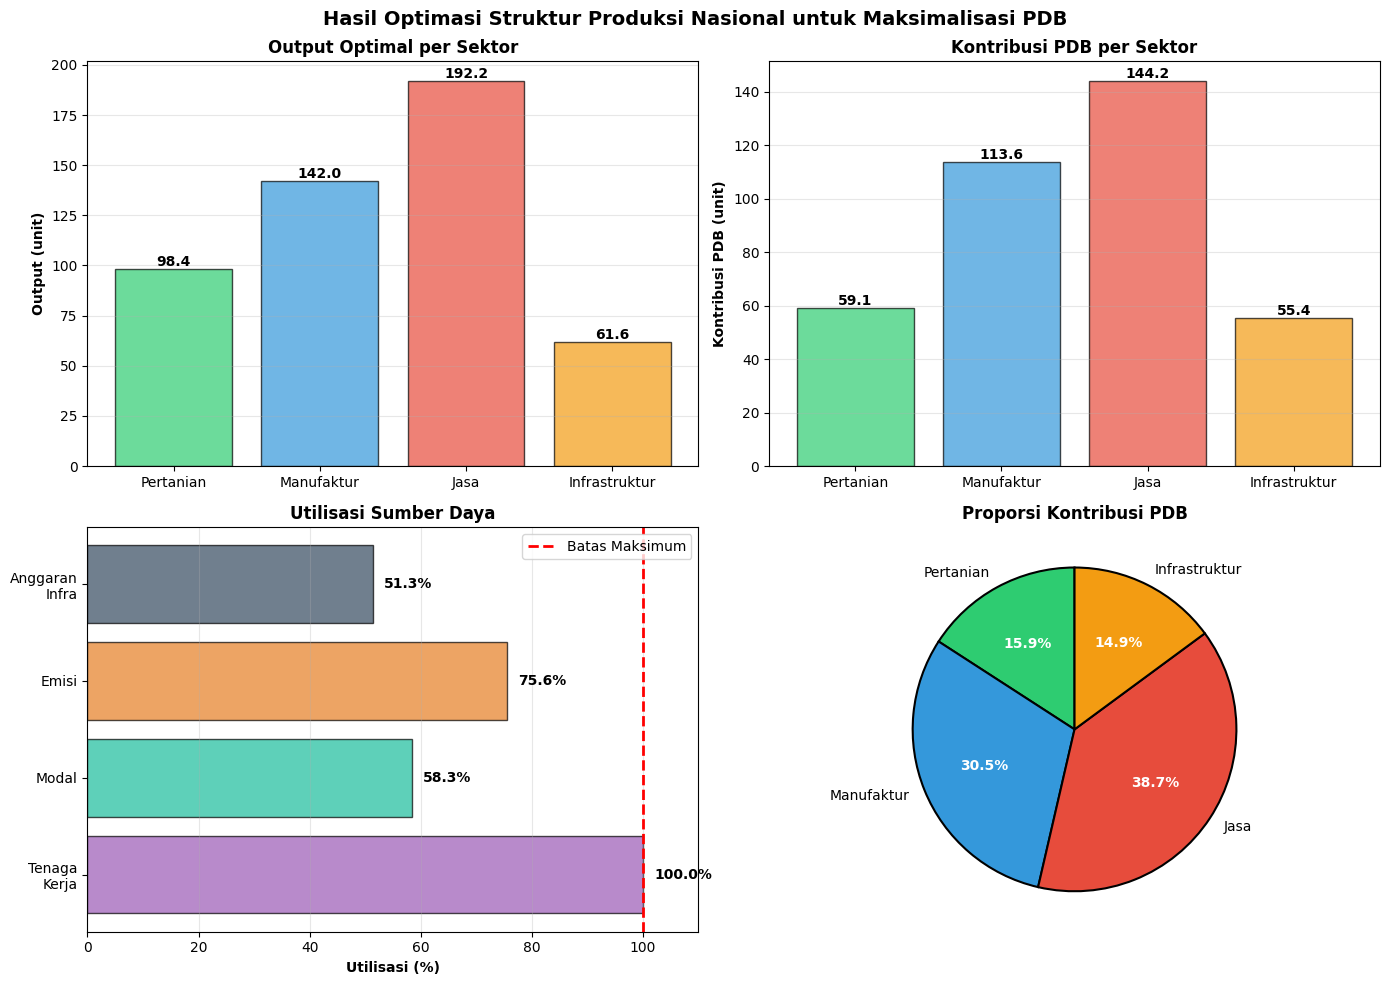

In [71]:
if solver and results.solver.termination_condition == pyo.TerminationCondition.optimal:

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Hasil Optimasi Struktur Produksi Nasional untuk Maksimalisasi PDB',
                 fontsize=14, fontweight='bold')

    ax1 = axes[0, 0]
    sectors_full = ['Pertanian', 'Manufaktur', 'Jasa', 'Infrastruktur']
    output_values = [optimal_production[i] for i in sectors]
    colors1 = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']

    bars1 = ax1.bar(sectors_full, output_values, color=colors1, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Output (unit)', fontweight='bold')
    ax1.set_title('Output Optimal per Sektor', fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars1, output_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

    ax2 = axes[0, 1]
    gdp_contributions = [optimal_production[i] * value_added[i] for i in sectors]

    bars2 = ax2.bar(sectors_full, gdp_contributions, color=colors1, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Kontribusi PDB (unit)', fontweight='bold')
    ax2.set_title('Kontribusi PDB per Sektor', fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    for bar, val in zip(bars2, gdp_contributions):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

    ax3 = axes[1, 0]
    resources = ['Tenaga\nKerja', 'Modal', 'Emisi', 'Anggaran\nInfra']
    used = [
        (labor_used / total_labor) * 100,
        (capital_used / total_capital) * 100,
        (emission_used / total_emission) * 100,
        (optimal_production['I'] / infra_budget) * 100
    ]

    bars3 = ax3.barh(resources, used, color=['#9b59b6', '#1abc9c', '#e67e22', '#34495e'],
                     alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Utilisasi (%)', fontweight='bold')
    ax3.set_title('Utilisasi Sumber Daya', fontweight='bold')
    ax3.axvline(x=100, color='red', linestyle='--', linewidth=2, label='Batas Maksimum')
    ax3.set_xlim(0, 110)
    ax3.grid(axis='x', alpha=0.3)
    ax3.legend()

    for bar, val in zip(bars3, used):
        width = bar.get_width()
        ax3.text(width + 2, bar.get_y() + bar.get_height()/2.,
                f'{val:.1f}%', ha='left', va='center', fontweight='bold')

    ax4 = axes[1, 1]
    gdp_pct = [(contrib / optimal_gdp) * 100 for contrib in gdp_contributions]

    wedges, texts, autotexts = ax4.pie(gdp_pct, labels=sectors_full, autopct='%1.1f%%',
                                         colors=colors1, startangle=90,
                                         wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    ax4.set_title('Proporsi Kontribusi PDB', fontweight='bold')

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)

    plt.tight_layout()
    plt.show()

else:
    print("\nError")
    print()


In [72]:
if solver and results.solver.termination_condition == pyo.TerminationCondition.optimal:

    print("\nRINGKASAN HASIL OPTIMASI:")
    print("="*60)
    print(f"PDB Maksimum         : {optimal_gdp:.2f} unit")
    print(f"Sektor Tertinggi     : {sector_names[contributions[0][0]]} ({contributions[0][1]:.2f})")
    print(f"Utilisasi Tenaga Kerja: {(labor_used/total_labor)*100:.1f}%")
    print(f"Utilisasi Modal      : {(capital_used/total_capital)*100:.1f}%")
    print(f"Utilisasi Emisi      : {(emission_used/total_emission)*100:.1f}%")
    print("="*60)


else:
    print("\nModel tidak menghasilkan solusi optimal")
    print()


RINGKASAN HASIL OPTIMASI:
PDB Maksimum         : 372.29 unit
Sektor Tertinggi     : Jasa (144.16)
Utilisasi Tenaga Kerja: 100.0%
Utilisasi Modal      : 58.3%
Utilisasi Emisi      : 75.6%


Kesimpulan Strategis

PDB maksimum 372.29 unit adalah batas yang bisa dicapai dengan kondisi sumber daya saat ini


Sektor Jasa (38.7%) dan Manufaktur (30.5%) adalah penyumbang utama, sehingga pemerintah harus:

Prioritaskan digitalisasi dan pengembangan ekonomi jasa
Dorong industrialisasi dan hilirisasi manufaktur
Investasi besar-besaran dalam infrastruktur digital dan teknologi


Tenaga kerja adalah constraint kritis yang harus segera ditangani:

Investasi pendidikan dan pelatihan vokasi
Program mekanisasi dan otomasi industri
Kebijakan untuk meningkatkan partisipasi angkatan kerja
Pertimbangkan kebijakan imigrasi tenaga kerja terampil


Modal bukan masalah saat ini (41.7% menganggur):

Tidak perlu stimulus investasi modal baru
Fokus pada pemanfaatan modal existing
Alihkan budget dari investasi modal ke pengembangan SDM



Rekomendasi utama: Pemerintah harus segera mengatasi bottleneck tenaga kerja melalui investasi masif dalam human capital development. Tanpa ini, semua sumber daya lain (modal, anggaran, kapasitas lingkungan) tidak akan bisa dimanfaatkan optimal dan PDB tidak akan bisa melampaui 372.29 unit.

In [73]:
demand_skema2 = {
    'A': 50 * 1.6,
    'M': 75 * 1.6,
    'S': 50 * 1.6,
    'I': 40 * 1.6
}

for sector in sectors:
    print(f"  {sector}: {demand[sector]:.0f} → {demand_skema2[sector]:.0f}")

  A: 50 → 80
  M: 75 → 120
  S: 50 → 80
  I: 40 → 64


In [74]:
model_milp = pyo.ConcreteModel(name="GDP_Optimization_MILP")

model_milp.sectors = pyo.Set(initialize=sectors)

model_milp.production = pyo.Var(model_milp.sectors, domain=pyo.NonNegativeReals)

model_milp.is_active = pyo.Var(model_milp.sectors, domain=pyo.Binary)


In [75]:
def objective_rule_milp(m):
    return sum(value_added[i] * m.production[i] for i in m.sectors)

model_milp.objective = pyo.Objective(rule=objective_rule_milp, sense=pyo.maximize)

print("Fungsi Objektif:")
print("  Maximize PDB = 0.6*p_A + 0.8*p_M + 0.75*p_S + 0.9*p_I")

Fungsi Objektif:
  Maximize PDB = 0.6*p_A + 0.8*p_M + 0.75*p_S + 0.9*p_I


In [76]:
# Constraint 1: Jika sektor aktif, produksi >= permintaan
M = 10000

def minimum_production_rule(m, i):
    return m.production[i] >= demand_skema2[i] * m.is_active[i]

model_milp.minimum_production = pyo.Constraint(model_milp.sectors, rule=minimum_production_rule)

def maximum_production_rule(m, i):
    return m.production[i] <= M * m.is_active[i]

model_milp.maximum_production = pyo.Constraint(model_milp.sectors, rule=maximum_production_rule)


# Constraint 2: Labor
def labor_constraint_rule_milp(m):
    return sum(labor_req[i] * m.production[i] for i in m.sectors) <= total_labor

model_milp.labor_constraint = pyo.Constraint(rule=labor_constraint_rule_milp)

print("Constraint 2: Labor")
print(f"  2*p_A + 3*p_M + 1*p_S + 3*p_I <= {total_labor}")
print()

# Constraint 3: Capital
def capital_constraint_rule_milp(m):
    return sum(capital_req[i] * m.production[i] for i in m.sectors) <= total_capital

model_milp.capital_constraint = pyo.Constraint(rule=capital_constraint_rule_milp)

print("Constraint 3: Capital")
print(f"  1.1*p_A + 2.0*p_M + 0.8*p_S + 2.5*p_I <= {total_capital}")
print()

# Constraint 4: Emission
def emission_constraint_rule_milp(m):
    return sum(emission_req[i] * m.production[i] for i in m.sectors) <= total_emission

model_milp.emission_constraint = pyo.Constraint(rule=emission_constraint_rule_milp)

print("Constraint 4: Emission")
print(f"  0.5*p_A + 0.9*p_M + 0.3*p_S + 1.1*p_I <= {total_emission}")
print()

# Constraint 5: Export limits
def export_abs_constraint_rule_milp(m, i):
    max_prod = export_abs_limit[i] / export_pct_limit[i]
    return m.production[i] <= max_prod

model_milp.export_constraint = pyo.Constraint(model_milp.sectors, rule=export_abs_constraint_rule_milp)

print("Constraint 5: Export")
print("  Produksi maksimum per sektor berdasarkan batasan ekspor")
print()

# Constraint 6: Infr\astructure budget
def infra_budget_constraint_rule_milp(m):
    return m.production['I'] <= infra_budget

model_milp.infra_budget_constraint = pyo.Constraint(rule=infra_budget_constraint_rule_milp)

print("Constraint 6: Infrastructure Budget")
print(f"  p_I <= {infra_budget}")
print()


Constraint 2: Labor
  2*p_A + 3*p_M + 1*p_S + 3*p_I <= 1000

Constraint 3: Capital
  1.1*p_A + 2.0*p_M + 0.8*p_S + 2.5*p_I <= 1200

Constraint 4: Emission
  0.5*p_A + 0.9*p_M + 0.3*p_S + 1.1*p_I <= 400

Constraint 5: Export
  Produksi maksimum per sektor berdasarkan batasan ekspor

Constraint 6: Infrastructure Budget
  p_I <= 120



In [77]:
results_milp = solver.solve(model_milp, tee=True)

print("-" * 60)

print("\nStatus Solusi MILP:")
print(f"  Termination Condition: {results_milp.solver.termination_condition}")
print(f"  Status: {results_milp.solver.status}")

if results_milp.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("  Solusi optimal ditemukan")
else:
    print(f"  Status: {results_milp.solver.termination_condition}")

print()


Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 16 rows; 8 cols; 33 nonzeros; 4 integer variables (4 binary)
Coefficient ranges:
  Matrix  [3e-01, 1e+04]
  Cost    [6e-01, 9e-01]
  Bound   [1e+00, 1e+00]
  RHS     [1e+02, 1e+03]
Presolving model
11 rows, 8 cols, 28 nonzeros  0s
10 rows, 8 cols, 24 nonzeros  0s
Presolve reductions: rows 10(-6); columns 8(-0); nonzeros 24(-9) 

Solving MIP model with:
   10 rows
   8 cols (4 binary, 0 integer, 0 implied int., 4 continuous, 0 domain fixed)
   24 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |            Objective Bou

In [78]:
if results_milp.solver.termination_condition == pyo.TerminationCondition.optimal:
    optimal_production_milp = {i: pyo.value(model_milp.production[i]) for i in sectors}
    optimal_active_milp = {i: pyo.value(model_milp.is_active[i]) for i in sectors}
    optimal_gdp_milp = pyo.value(model_milp.objective)

    print("\n" + "="*60)
    print("HASIL OPTIMASI MILP - SEKTOR AKTIF/TIDAK AKTIF")
    print("="*60)

    results_milp_df = pd.DataFrame({
        'Sektor': ['Pertanian (A)', 'Manufaktur (M)', 'Jasa (S)', 'Infrastruktur (I)'],
        'Kode': sectors,
        'Status': ['AKTIF' if optimal_active_milp[i] > 0.5 else 'TIDAK AKTIF' for i in sectors],
        'Output': [optimal_production_milp[i] for i in sectors],
        'Permintaan': [demand_skema2[i] for i in sectors],
        'Kontribusi PDB': [optimal_production_milp[i] * value_added[i] for i in sectors]
    })

    print(results_milp_df.to_string(index=False))
    print("="*60)
    print(f"TOTAL PDB MAKSIMUM (MILP): {optimal_gdp_milp:.2f}")
    print("="*60)
    print()

    print("\n" + "="*60)
    print("ANALISIS PENGGUNAAN SUMBER DAYA (MILP)")
    print("="*60)

    labor_used_milp = sum(labor_req[i] * optimal_production_milp[i] for i in sectors)
    print(f"Tenaga Kerja:")
    print(f"  Terpakai: {labor_used_milp:.2f} / {total_labor}")
    print(f"  Utilisasi: {(labor_used_milp/total_labor)*100:.1f}%")
    print()

    capital_used_milp = sum(capital_req[i] * optimal_production_milp[i] for i in sectors)
    print(f"Modal:")
    print(f"  Terpakai: {capital_used_milp:.2f} / {total_capital}")
    print(f"  Utilisasi: {(capital_used_milp/total_capital)*100:.1f}%")
    print()

    emission_used_milp = sum(emission_req[i] * optimal_production_milp[i] for i in sectors)
    print(f"Emisi:")
    print(f"  Terpakai: {emission_used_milp:.2f} / {total_emission}")
    print(f"  Utilisasi: {(emission_used_milp/total_emission)*100:.1f}%")
    print()

else:
    print("\nModel MILP tidak menghasilkan solusi optimal")
    print()



HASIL OPTIMASI MILP - SEKTOR AKTIF/TIDAK AKTIF
           Sektor Kode      Status  Output  Permintaan  Kontribusi PDB
    Pertanian (A)    A       AKTIF   200.0        80.0           120.0
   Manufaktur (M)    M TIDAK AKTIF     0.0       120.0             0.0
         Jasa (S)    S       AKTIF   200.0        80.0           150.0
Infrastruktur (I)    I       AKTIF   120.0        64.0           108.0
TOTAL PDB MAKSIMUM (MILP): 378.00


ANALISIS PENGGUNAAN SUMBER DAYA (MILP)
Tenaga Kerja:
  Terpakai: 960.00 / 1000
  Utilisasi: 96.0%

Modal:
  Terpakai: 680.00 / 1200
  Utilisasi: 56.7%

Emisi:
  Terpakai: 292.00 / 400
  Utilisasi: 73.0%



In [79]:
total_emission_tight = 300

model_milp_tight = pyo.ConcreteModel(name="GDP_MILP_Tight_Emission")
model_milp_tight.sectors = pyo.Set(initialize=sectors)
model_milp_tight.production = pyo.Var(model_milp_tight.sectors, domain=pyo.NonNegativeReals)
model_milp_tight.is_active = pyo.Var(model_milp_tight.sectors, domain=pyo.Binary)

def objective_rule_tight(m):
    return sum(value_added[i] * m.production[i] for i in m.sectors)
model_milp_tight.objective = pyo.Objective(rule=objective_rule_tight, sense=pyo.maximize)

def minimum_production_rule_tight(m, i):
    return m.production[i] >= demand_skema2[i] * m.is_active[i]
model_milp_tight.minimum_production = pyo.Constraint(model_milp_tight.sectors, rule=minimum_production_rule_tight)

def maximum_production_rule_tight(m, i):
    return m.production[i] <= M * m.is_active[i]
model_milp_tight.maximum_production = pyo.Constraint(model_milp_tight.sectors, rule=maximum_production_rule_tight)

def labor_constraint_rule_tight(m):
    return sum(labor_req[i] * m.production[i] for i in m.sectors) <= total_labor
model_milp_tight.labor_constraint = pyo.Constraint(rule=labor_constraint_rule_tight)

def capital_constraint_rule_tight(m):
    return sum(capital_req[i] * m.production[i] for i in m.sectors) <= total_capital
model_milp_tight.capital_constraint = pyo.Constraint(rule=capital_constraint_rule_tight)

def emission_constraint_rule_tight(m):
    return sum(emission_req[i] * m.production[i] for i in m.sectors) <= total_emission_tight
model_milp_tight.emission_constraint = pyo.Constraint(rule=emission_constraint_rule_tight)

def export_abs_constraint_rule_tight(m, i):
    max_prod = export_abs_limit[i] / export_pct_limit[i]
    return m.production[i] <= max_prod
model_milp_tight.export_constraint = pyo.Constraint(model_milp_tight.sectors, rule=export_abs_constraint_rule_tight)

def infra_budget_constraint_rule_tight(m):
    return m.production['I'] <= infra_budget
model_milp_tight.infra_budget_constraint = pyo.Constraint(rule=infra_budget_constraint_rule_tight)

results_tight = solver.solve(model_milp_tight, tee=False)

if results_tight.solver.termination_condition == pyo.TerminationCondition.optimal:
    optimal_production_tight = {i: pyo.value(model_milp_tight.production[i]) for i in sectors}
    optimal_active_tight = {i: pyo.value(model_milp_tight.is_active[i]) for i in sectors}
    optimal_gdp_tight = pyo.value(model_milp_tight.objective)
    print("\n" + "="*60)
    print("HASIL DENGAN EMISI KETAT")
    print("="*60)

    results_tight_df = pd.DataFrame({
        'Sektor': ['Pertanian (A)', 'Manufaktur (M)', 'Jasa (S)', 'Infrastruktur (I)'],
        'Status Normal': ['AKTIF' if optimal_active_milp[i] > 0.5 else 'TIDAK AKTIF' for i in sectors],
        'Status Ketat': ['AKTIF' if optimal_active_tight[i] > 0.5 else 'TIDAK AKTIF' for i in sectors],
        'Output Ketat': [optimal_production_tight[i] for i in sectors],
        'Kontribusi PDB': [optimal_production_tight[i] * value_added[i] for i in sectors]
    })

    print(results_tight_df.to_string(index=False))
    print("="*60)
    print(f"PDB MILP Normal  : {optimal_gdp_milp:.2f}")
    print(f"PDB MILP Ketat   : {optimal_gdp_tight:.2f}")
    print(f"Penurunan PDB    : {optimal_gdp_milp - optimal_gdp_tight:.2f} ({((optimal_gdp_tight/optimal_gdp_milp - 1)*100):.2f}%)")
    print("="*60)

    print("\nDAMPAK EMISI KETAT:")
    print("-"*60)
    active_tight = [i for i in sectors if optimal_active_tight[i] > 0.5]
    inactive_tight = [i for i in sectors if optimal_active_tight[i] <= 0.5]

    changed_status = []
    for i in sectors:
        was_active = optimal_active_milp[i] > 0.5
        now_active = optimal_active_tight[i] > 0.5
        if was_active != now_active:
            changed_status.append((i, was_active, now_active))

    if changed_status:
        print("Sektor yang berubah status:")
        for s, was_active, now_active in changed_status:
            status_change = "AKTIF → TIDAK AKTIF" if was_active else "TIDAK AKTIF → AKTIF"
            print(f"  - {sector_names[s]}: {status_change}")
            print(f"    (Emisi per unit: {emission_req[s]})")
    else:
        print("Tidak ada perubahan status sektor (aktif/tidak aktif)")

    emission_used_tight = sum(emission_req[i] * optimal_production_tight[i] for i in sectors)
    print(f"\nEmisi terpakai: {emission_used_tight:.2f} / {total_emission_tight}")
    print(f"Utilisasi: {(emission_used_tight/total_emission_tight)*100:.1f}%")
    print()

else:
    print("\nModel dengan emisi ketat tidak menghasilkan solusi optimal")
    print()




HASIL DENGAN EMISI KETAT
           Sektor Status Normal Status Ketat  Output Ketat  Kontribusi PDB
    Pertanian (A)         AKTIF        AKTIF         200.0           120.0
   Manufaktur (M)   TIDAK AKTIF  TIDAK AKTIF           0.0             0.0
         Jasa (S)         AKTIF        AKTIF         200.0           150.0
Infrastruktur (I)         AKTIF        AKTIF         120.0           108.0
PDB MILP Normal  : 378.00
PDB MILP Ketat   : 378.00
Penurunan PDB    : 0.00 (0.00%)

DAMPAK EMISI KETAT:
------------------------------------------------------------
Tidak ada perubahan status sektor (aktif/tidak aktif)

Emisi terpakai: 292.00 / 300
Utilisasi: 97.3%



In [80]:
total_labor_reduced = 500

model_milp_labor = pyo.ConcreteModel(name="GDP_MILP_Reduced_Labor")
model_milp_labor.sectors = pyo.Set(initialize=sectors)
model_milp_labor.production = pyo.Var(model_milp_labor.sectors, domain=pyo.NonNegativeReals)
model_milp_labor.is_active = pyo.Var(model_milp_labor.sectors, domain=pyo.Binary)

def objective_rule_labor(m):
    return sum(value_added[i] * m.production[i] for i in m.sectors)
model_milp_labor.objective = pyo.Objective(rule=objective_rule_labor, sense=pyo.maximize)

def minimum_production_rule_labor(m, i):
    return m.production[i] >= demand_skema2[i] * m.is_active[i]
model_milp_labor.minimum_production = pyo.Constraint(model_milp_labor.sectors, rule=minimum_production_rule_labor)

def maximum_production_rule_labor(m, i):
    return m.production[i] <= M * m.is_active[i]
model_milp_labor.maximum_production = pyo.Constraint(model_milp_labor.sectors, rule=maximum_production_rule_labor)

def labor_constraint_rule_labor(m):
    return sum(labor_req[i] * m.production[i] for i in m.sectors) <= total_labor_reduced
model_milp_labor.labor_constraint = pyo.Constraint(rule=labor_constraint_rule_labor)

def capital_constraint_rule_labor(m):
    return sum(capital_req[i] * m.production[i] for i in m.sectors) <= total_capital
model_milp_labor.capital_constraint = pyo.Constraint(rule=capital_constraint_rule_labor)

def emission_constraint_rule_labor(m):
    return sum(emission_req[i] * m.production[i] for i in m.sectors) <= total_emission
model_milp_labor.emission_constraint = pyo.Constraint(rule=emission_constraint_rule_labor)

def export_abs_constraint_rule_labor(m, i):
    max_prod = export_abs_limit[i] / export_pct_limit[i]
    return m.production[i] <= max_prod
model_milp_labor.export_constraint = pyo.Constraint(model_milp_labor.sectors, rule=export_abs_constraint_rule_labor)

def infra_budget_constraint_rule_labor(m):
    return m.production['I'] <= infra_budget
model_milp_labor.infra_budget_constraint = pyo.Constraint(rule=infra_budget_constraint_rule_labor)

results_labor = solver.solve(model_milp_labor, tee=False)

if results_labor.solver.termination_condition == pyo.TerminationCondition.optimal:
    optimal_production_labor = {i: pyo.value(model_milp_labor.production[i]) for i in sectors}
    optimal_active_labor = {i: pyo.value(model_milp_labor.is_active[i]) for i in sectors}
    optimal_gdp_labor = pyo.value(model_milp_labor.objective)

    print("\n" + "="*60)
    print("HASIL DENGAN TENAGA KERJA TERBATAS")
    print("="*60)

    try:
        _ = optimal_active_milp
        _ = optimal_gdp_milp
    except NameError:
        optimal_active_milp = {i: 0 for i in sectors}
        optimal_gdp_milp = None

    results_labor_df = pd.DataFrame({
        'Sektor': ['Pertanian (A)', 'Manufaktur (M)', 'Jasa (S)', 'Infrastruktur (I)'],
        'Kode': sectors,
        'Status Normal': ['AKTIF' if optimal_active_milp[i] > 0.5 else 'TIDAK AKTIF' for i in sectors],
        'Status Terbatas': ['AKTIF' if optimal_active_labor[i] > 0.5 else 'TIDAK AKTIF' for i in sectors],
        'Output': [optimal_production_labor[i] for i in sectors],
        'Labor/Unit': [labor_req[i] for i in sectors],
        'Kontribusi PDB': [optimal_production_labor[i] * value_added[i] for i in sectors]
    })

    print(results_labor_df.to_string(index=False))
    print("="*60)
    if optimal_gdp_milp is not None:
        if optimal_gdp_milp != 0:
            pct_change = (optimal_gdp_labor/optimal_gdp_milp - 1)*100
        else:
            pct_change = float('nan')
        print(f"PDB MILP Normal      : {optimal_gdp_milp:.2f}")
    else:
        print("PDB MILP Normal      : (hasil model normal tidak tersedia)")
        pct_change = float('nan')
    print(f"PDB MILP Terbatas    : {optimal_gdp_labor:.2f}")
    if not (pct_change != pct_change):
        print(f"Penurunan PDB        : { (optimal_gdp_milp - optimal_gdp_labor):.2f} ({pct_change:.2f}%)")
    else:
        print(f"Penurunan PDB        : { (optimal_gdp_milp - optimal_gdp_labor) if optimal_gdp_milp is not None else 'N/A' }")
    print("="*60)

    print("\nDAMPAK TENAGA KERJA TERBATAS:")
    print("-"*60)

    changed_status_labor = []
    for i in sectors:
        was_active = optimal_active_milp.get(i, 0) > 0.5
        now_active = optimal_active_labor[i] > 0.5
        if was_active != now_active:
            changed_status_labor.append((i, was_active, now_active))

    if changed_status_labor:
        print("Sektor yang berubah status:")
        for s, was_active, now_active in changed_status_labor:
            status_change = "AKTIF → TIDAK AKTIF" if was_active else "TIDAK AKTIF → AKTIF"
            print(f"  - {sector_names[s]}: {status_change}")
            print(f"    (Tenaga kerja per unit: {labor_req[s]})")
            efficiency = value_added[s] / labor_req[s]
            print(f"    (Efisiensi nilai tambah/labor: {efficiency:.2f})")
    else:
        print("Tidak ada perubahan status sektor")

    labor_used_reduced = sum(labor_req[i] * optimal_production_labor[i] for i in sectors)
    print(f"\nTenaga kerja terpakai: {labor_used_reduced:.2f} / {total_labor_reduced}")
    print(f"Utilisasi: {(labor_used_reduced/total_labor_reduced)*100:.1f}%")

    print("\nPRIORITAS SEKTOR BERDASARKAN EFISIENSI TENAGA KERJA:")
    efficiency_ranking = [(i, value_added[i]/labor_req[i]) for i in sectors]
    efficiency_ranking.sort(key=lambda x: x[1], reverse=True)
    for rank, (s, eff) in enumerate(efficiency_ranking, 1):
        status = "AKTIF" if optimal_active_labor[s] > 0.5 else "TIDAK AKTIF"
        print(f"  {rank}. {sector_names[s]:15} - Efisiensi: {eff:.3f} [{status}]")
    print()

else:
    print("\nModel dengan tenaga kerja terbatas tidak menghasilkan solusi optimal")
    print()



HASIL DENGAN TENAGA KERJA TERBATAS
           Sektor Kode Status Normal Status Terbatas  Output  Labor/Unit  Kontribusi PDB
    Pertanian (A)    A         AKTIF           AKTIF   150.0           2            90.0
   Manufaktur (M)    M   TIDAK AKTIF     TIDAK AKTIF     0.0           3             0.0
         Jasa (S)    S         AKTIF           AKTIF   200.0           1           150.0
Infrastruktur (I)    I         AKTIF     TIDAK AKTIF     0.0           3             0.0
PDB MILP Normal      : 378.00
PDB MILP Terbatas    : 240.00
Penurunan PDB        : 138.00 (-36.51%)

DAMPAK TENAGA KERJA TERBATAS:
------------------------------------------------------------
Sektor yang berubah status:
  - Infrastruktur: AKTIF → TIDAK AKTIF
    (Tenaga kerja per unit: 3)
    (Efisiensi nilai tambah/labor: 0.30)

Tenaga kerja terpakai: 500.00 / 500
Utilisasi: 100.0%

PRIORITAS SEKTOR BERDASARKAN EFISIENSI TENAGA KERJA:
  1. Jasa            - Efisiensi: 0.750 [AKTIF]
  2. Pertanian       - Efisiens

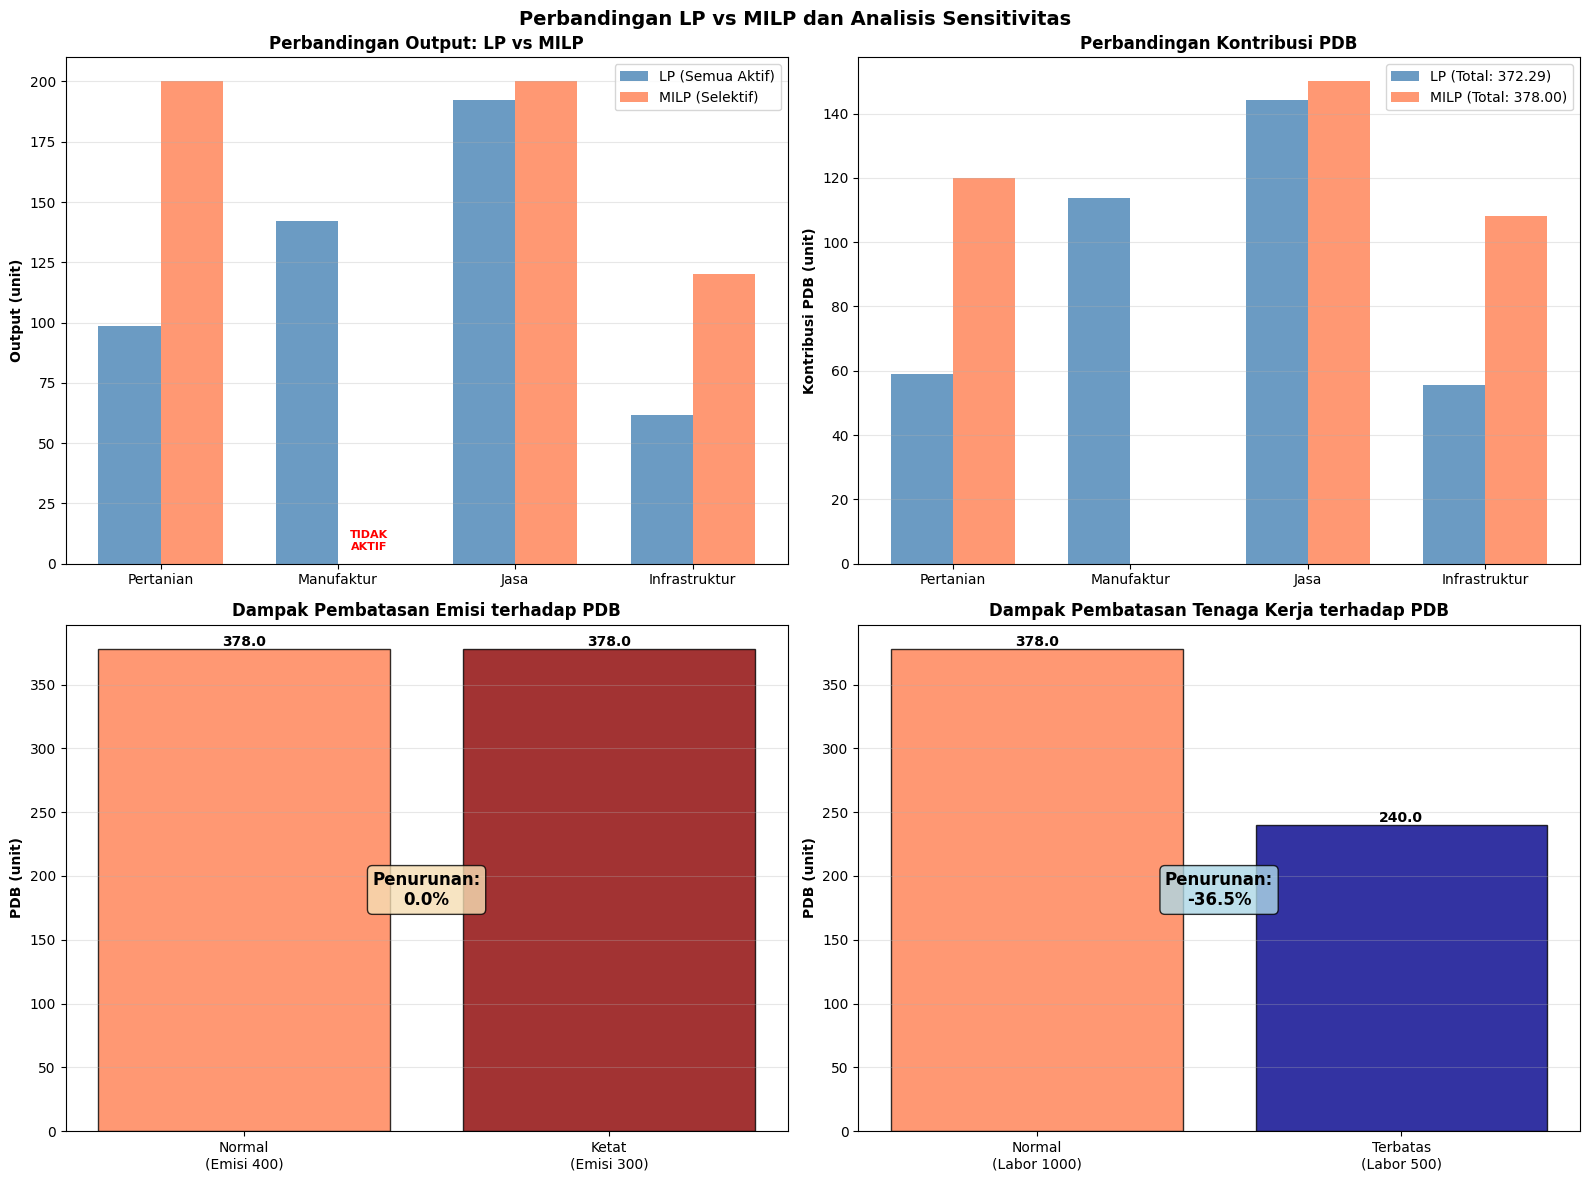

In [ ]:
if (results.solver.termination_condition == pyo.TerminationCondition.optimal and
    results_milp.solver.termination_condition == pyo.TerminationCondition.optimal):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Perbandingan LP vs MILP dan Analisis Sensitivitas',
                 fontsize=14, fontweight='bold')

    ax1 = axes[0, 0]
    x = np.arange(len(sectors))
    width = 0.35

    bars1_lp = ax1.bar(x - width/2, [optimal_production[i] for i in sectors],
                       width, label='LP (Semua Aktif)', color='steelblue', alpha=0.8)
    bars1_milp = ax1.bar(x + width/2, [optimal_production_milp[i] for i in sectors],
                         width, label='MILP (Selektif)', color='coral', alpha=0.8)

    ax1.set_ylabel('Output (unit)', fontweight='bold')
    ax1.set_title('Perbandingan Output: LP vs MILP', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Pertanian', 'Manufaktur', 'Jasa', 'Infrastruktur'])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    for i, s in enumerate(sectors):
        if optimal_active_milp[s] <= 0.5:
            ax1.text(i + width/2, optimal_production_milp[s] + 5,
                    'TIDAK\nAKTIF', ha='center', va='bottom',
                    fontsize=8, color='red', fontweight='bold')

    ax2 = axes[0, 1]

    gdp_lp = [optimal_production[i] * value_added[i] for i in sectors]
    gdp_milp = [optimal_production_milp[i] * value_added[i] for i in sectors]

    bars2_lp = ax2.bar(x - width/2, gdp_lp, width,
                       label=f'LP (Total: {optimal_gdp:.2f})',
                       color='steelblue', alpha=0.8)
    bars2_milp = ax2.bar(x + width/2, gdp_milp, width,
                         label=f'MILP (Total: {optimal_gdp_milp:.2f})',
                         color='coral', alpha=0.8)

    ax2.set_ylabel('Kontribusi PDB (unit)', fontweight='bold')
    ax2.set_title('Perbandingan Kontribusi PDB', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Pertanian', 'Manufaktur', 'Jasa', 'Infrastruktur'])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    ax3 = axes[1, 0]

    if results_tight.solver.termination_condition == pyo.TerminationCondition.optimal:
        gdp_scenarios = [optimal_gdp_milp, optimal_gdp_tight]
        emission_limits = [total_emission, total_emission_tight]
        colors_emission = ['coral', 'darkred']

        bars3 = ax3.bar(['Normal\n(Emisi 400)', 'Ketat\n(Emisi 300)'],
                        gdp_scenarios, color=colors_emission, alpha=0.8, edgecolor='black')

        ax3.set_ylabel('PDB (unit)', fontweight='bold')
        ax3.set_title('Dampak Pembatasan Emisi terhadap PDB', fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)

        for bar, val in zip(bars3, gdp_scenarios):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

        pct_decrease = ((optimal_gdp_tight/optimal_gdp_milp - 1) * 100)
        ax3.text(0.5, max(gdp_scenarios) * 0.5,
                f'Penurunan:\n{pct_decrease:.1f}%',
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontweight='bold')

    ax4 = axes[1, 1]

    if results_labor.solver.termination_condition == pyo.TerminationCondition.optimal:
        gdp_labor_scenarios = [optimal_gdp_milp, optimal_gdp_labor]
        labor_limits = [total_labor, total_labor_reduced]
        colors_labor = ['coral', 'darkblue']

        bars4 = ax4.bar(['Normal\n(Labor 1000)', 'Terbatas\n(Labor 500)'],
                        gdp_labor_scenarios, color=colors_labor, alpha=0.8, edgecolor='black')

        ax4.set_ylabel('PDB (unit)', fontweight='bold')
        ax4.set_title('Dampak Pembatasan Tenaga Kerja terhadap PDB', fontweight='bold')
        ax4.grid(axis='y', alpha=0.3)

        for bar, val in zip(bars4, gdp_labor_scenarios):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

        pct_decrease_labor = ((optimal_gdp_labor/optimal_gdp_milp - 1) * 100)
        ax4.text(0.5, max(gdp_labor_scenarios) * 0.5,
                f'Penurunan:\n{pct_decrease_labor:.1f}%',
                ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("\nTidak dapat membuat visualisasi karena model tidak optimal")
    print()